# Modeling Fox's Wake-Up Behavior
## Table of Contents
1. [Imports](#imports)
2. [Reading in Data](#read)
3. [Reducing Noise](#noise)
4. [Modeling](#Modeling)

<a id = 'imports'></a>
## Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

<a id = 'read'></a>
## Reading in Data

In [2]:
df_frames = pd.read_csv('../data/fox-falco-fd-frames.csv')
df_frames.head()

,Unnamed: 0,game_id,frame_index,fox_cstick_x,fox_cstick_y,fox_joystick_x,fox_joystick_y,fox_trigger_analog,fox_Y,fox_X,...,falco_combo_count,falco_dmg,falco_direction,falco_last_hit_by,falco_position_x,falco_position_y,falco_shield,falco_state,falco_state_age,falco_stocks
0,0,20190406T144505,-123,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,1,NaN,-60.0,10.0,60.0,322,-1.0,4
1,1,20190406T144505,-122,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,1,NaN,-60.0,10.0,60.0,322,-1.0,4
2,2,20190406T144505,-121,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,1,NaN,-60.0,10.0,60.0,322,-1.0,4
3,3,20190406T144505,-120,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,1,NaN,-60.0,10.0,60.0,322,-1.0,4
4,4,20190406T144505,-119,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,1,NaN,-60.0,10.0,60.0,322,-1.0,4


In [3]:
df_frames.drop(columns = ['Unnamed: 0', 'fox_last_hit_by', 'falco_last_hit_by'], inplace = True)
df_frames.head()

,game_id,frame_index,fox_cstick_x,fox_cstick_y,fox_joystick_x,fox_joystick_y,fox_trigger_analog,fox_Y,fox_X,fox_B,...,falco_Dpad_Left,falco_combo_count,falco_dmg,falco_direction,falco_position_x,falco_position_y,falco_shield,falco_state,falco_state_age,falco_stocks
0,20190406T144505,-123,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,1,-60.0,10.0,60.0,322,-1.0,4
1,20190406T144505,-122,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,1,-60.0,10.0,60.0,322,-1.0,4
2,20190406T144505,-121,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,1,-60.0,10.0,60.0,322,-1.0,4
3,20190406T144505,-120,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,1,-60.0,10.0,60.0,322,-1.0,4
4,20190406T144505,-119,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,1,-60.0,10.0,60.0,322,-1.0,4


<a id = "noise"></a>
## Reducing Noise

Action States 322, 323, and 324 are useless because they are the states of the game starting, so we will drop them.
Planned on removing all frames in which both characters are on the ground because those are not needed to predict get-up options. If `game` is a Game object, then I can access this information with `game.frames[frame_index].ports[active_port_index].leader.post.ground`. The problem is that this information is not tracked for the games recorded at Fight Pitt 9. I believe this information is recorded for more recent versions of Slippi.

In [4]:
# Establish which action state values explain nothing
useless_states = [322, 323, 324]

# Provide the rows that are not (~) in the useless-states list for Fox and Falco
df_frames = df_frames.loc[(~df_frames['fox_state'].isin(useless_states)) | (~df_frames['falco_state'].isin(useless_states))]
df_frames.reset_index(inplace = True, drop = True)
df_frames.head()

,game_id,frame_index,fox_cstick_x,fox_cstick_y,fox_joystick_x,fox_joystick_y,fox_trigger_analog,fox_Y,fox_X,fox_B,...,falco_Dpad_Left,falco_combo_count,falco_dmg,falco_direction,falco_position_x,falco_position_y,falco_shield,falco_state,falco_state_age,falco_stocks
0,20190406T144505,-49,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,1,-60.0,9.872425,60.0,29,0.0,4
1,20190406T144505,-48,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,1,-60.0,9.532425,60.0,29,1.0,4
2,20190406T144505,-47,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,1,-60.0,9.022425,60.0,29,2.0,4
3,20190406T144505,-46,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,1,-60.0,8.342424,60.0,29,3.0,4
4,20190406T144505,-45,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,1,-60.0,7.492424,60.0,29,4.0,4


Each missed tech animation has different values, but can be interpreted the same way. Thanks to these, we can collapse all of these values to the same value.

In [5]:
# Map all missed tech values as the same value
missed_tech = [183, 188, 189, 191, 196, 197]
df_frames['fox_state'] = df_frames['fox_state'].apply(lambda val: val if val not in missed_tech else 999)

In [6]:
# Map [missed tech, tech in place, tech-roll forward, tech-roll backward] to their respective values in the target column
missed_and_techs = [999, 199, 200, 201]
df_frames['target'] = df_frames['fox_state'].apply(lambda val: 0 if val not in missed_and_techs else (1 if val == 999 else (2 if val == 199 else (3 if val == 200 else 4))))

| Target Value |         Meaning         |
|:------------:|:-----------------------:|
|       0      | Not a tech situation |
|       1      |       Missed tech       |
|       2      |      Tech in-place      |
|       3      |    Tech-roll forward    |
|       4      |    Tech-roll backward   |

In [7]:
# class imbalance
df_frames['target'].value_counts(normalize = True)

0    0.967356
1    0.019924
2    0.005484
4    0.004848
3    0.002388
Name: target, dtype: float64

In [8]:
df_frames['target'].value_counts()

0    92782
1     1911
2      526
4      465
3      229
Name: target, dtype: int64

The baseline accuracy for our multi-classification RNN is 96.74%.

In [9]:
# Now we need to categorize these values
df_frames = pd.get_dummies(df_frames, columns = ['fox_state', 'falco_state', 'fox_direction', 'falco_direction'])
df_frames.head()

,game_id,frame_index,fox_cstick_x,fox_cstick_y,fox_joystick_x,fox_joystick_y,fox_trigger_analog,fox_Y,fox_X,fox_B,...,falco_state_440,falco_state_441,falco_state_442,falco_state_443,falco_state_445,falco_state_446,fox_direction_-1,fox_direction_1,falco_direction_-1,falco_direction_1
0,20190406T144505,-49,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,20190406T144505,-48,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,20190406T144505,-47,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,20190406T144505,-46,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,20190406T144505,-45,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


## Modeling

In [10]:
# Establishing X features and y target column
X = df_frames.drop(columns = ['game_id', 'frame_index', 'target'])
y = to_categorical(df_frames['target'])

In [11]:
X.shape

(95913, 341)

In [12]:
y.shape

(95913, 5)

In [13]:
# Since I cannot set random_state to 20XX, I will set it to 2099
# Joke: https://knowyourmeme.com/memes/20xx
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, random_state = 2099)

In [14]:
# Scaling our data
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [15]:
X_train.shape

(71934, 341)

In [16]:
Z_train.shape

(71934, 341)

In [17]:
train_sequences = TimeseriesGenerator(Z_train, y_train,
                                     length = 120, batch_size = 512)

In [18]:
train_sequences[0][0].shape

(512, 120, 341)

In [19]:
test_sequences = TimeseriesGenerator(Z_test, y_test,
                                     length = train_sequences[0][0].shape[1],
                                     batch_size = train_sequences[0][0].shape[0])

In [20]:
# Constructing the model topology
model = Sequential()

# The input layer
model.add(GRU(train_sequences[0][0].shape[2], input_shape = (train_sequences[0][0].shape[1], train_sequences[0][0].shape[2]), return_sequences = True))
# Send the output of 120 past frames back to this layer
model.add(GRU(train_sequences[0][0].shape[2], return_sequences = False))

# A hidden layer of 128 nodes with ReLu activation function
model.add(Dense(128, activation = 'relu'))

# The output layer with 5 nodes, one for each target class
model.add(Dense(5, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.001), metrics = ['accuracy'])

In [21]:
# Fit the model 
hist = model.fit_generator(train_sequences, epochs = 5, validation_data = test_sequences)

Epoch 1/5
141/141 [==============================] - 2513s 18s/step - loss: 0.1649 - accuracy: 0.9520 - val_loss: 0.0177 - val_accuracy: 0.9965
Epoch 2/5
141/141 [==============================] - 2449s 17s/step - loss: 0.0200 - accuracy: 0.9950 - val_loss: 0.0175 - val_accuracy: 0.9967
Epoch 3/5
141/141 [==============================] - 2206s 16s/step - loss: 0.0172 - accuracy: 0.9964 - val_loss: 0.0131 - val_accuracy: 0.9975
Epoch 4/5
141/141 [==============================] - 2097s 15s/step - loss: 0.0119 - accuracy: 0.9974 - val_loss: 0.0118 - val_accuracy: 0.9976
Epoch 5/5
141/141 [==============================] - 2476s 18s/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0.0115 - val_accuracy: 0.9977


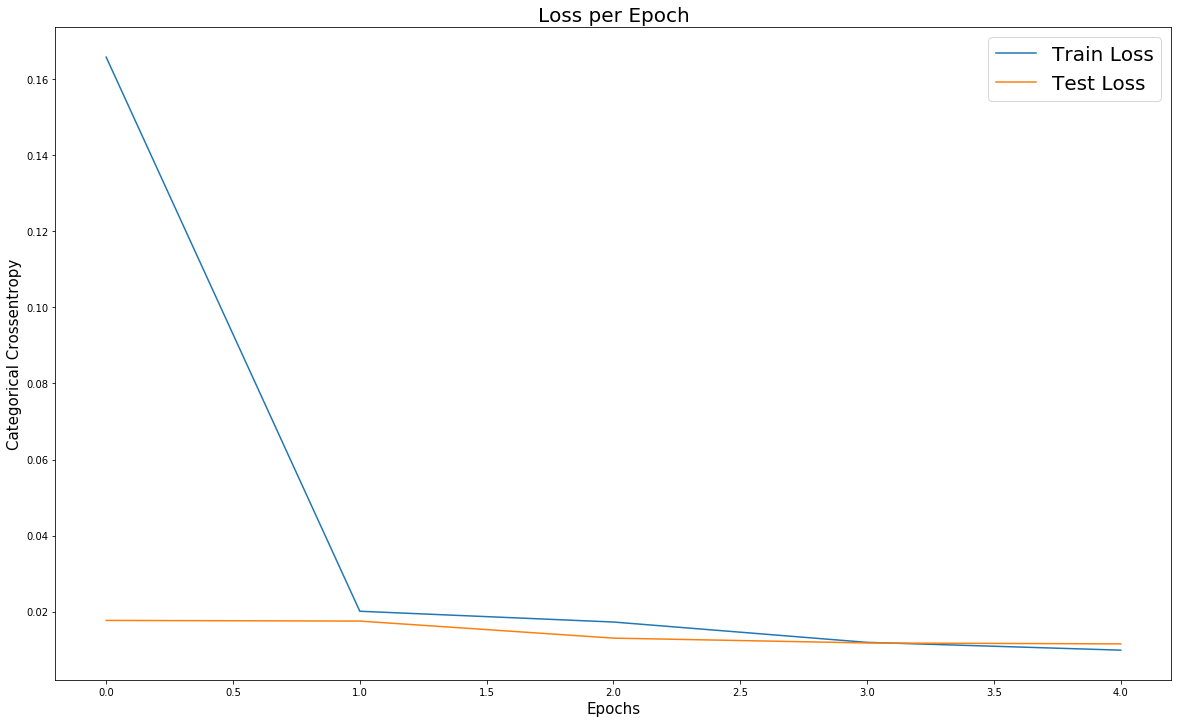

In [22]:
plt.figure(figsize = (20, 12))
plt.title('Loss per Epoch', size = 20);
plt.xlabel('Epochs', size = 15)
plt.ylabel('Categorical Crossentropy', size = 15)
plt.plot(hist.history['loss'], label = 'Train Loss');
plt.plot(hist.history['val_loss'], label = 'Test Loss');
plt.legend(prop = {'size': 20});


## Conclusions and Future Work
_<center>Loss and accuracy scores after fitting model</center>_

| Train Loss | Test Loss | Baseline Accuracy | Train Accuracy | Test Accuracy |
|:----------:|:---------:|:-----------------:|:--------------:|:-------------:|
|   0.0091   |   0.0186  |       96.63%      |     99.76%     |     99.63%    |

After fitting the model, the loss on the training sequence is 0.0091 and the loss on the validation sequence is 0.0186]. This tells me that my model is overfit because the categorical crossentropy of the training sequences is less than the categorical crossentropy of the testing sequences (validation data). This can also be seen when looking at the train and test accuracies. Considering that my baseline accuracy score is 96.63% and my model has a training accuracy of 99.76% and a test accuracy of 99.63%, I have a model that is better at predicting Fox's tech behavior than randomly guessing. However, it is important to note that the reason that the accuracy score is so high is because majority of the target values are 0's. These 0's represent frames in which Fox is in an action state that does not signify whether he is teching or missing a tech. For example, Fox could be standing, jumping, or attacking.

I would also like to point out the behavior of the test loss. One will notice that the categorical crossentropy at the end of fitting barely shows a difference compared to the categorical crossentropy at the beginning of fitting. This tells me that the training does not have much of an affect on the testing. I believe this is because there is so much random noise for the model to train on that it does not help it predict unseen data at all. So the further versions of this product will need to programmatically find the useful frames that can explain a Fox player's tech habits.

With this in mind I will disregard regularization for now because there is no need to improve this model unless the data that is fed into the model has the useless noise removed. This can be done by locating the frames in which a missed tech, tech in place, tech roll left, or tech roll right is detected. Then I will go back 120 frames and label them as important sequences where 120 is the amount of sequential frames I want to feed to the RNN. By doing this, I can drop the frames that are not labeled as important. This way, I only retain frames that lead up to a wake-up situation. When creating this function, I will also need to construct multiple models that take in sequences of different lengths. I will create models that label 120 frames to 300 frames in 30 frame intervals. In units of seconds, 2 seconds to 5 seconds in 0.5 second intervals. Then for each interval, I will fit a model and determine which number of sequential frames is enough to train a model.

Another problem in the model is the data that is being fed as input. As mentioned before, the data is being inputted as one large sequence of frames. Similar to taping 13 different movie film reels together, we are "taping" 13 different games together for the model to interpret as one large game. This will cause a problem because when the model begins to interpret the frames that are "taped" together, then it will take the history of the previous, independent game and assume it will have an affect on the current game. This is not true at all. To deal with this, I will do research on various types of gates that can be applied to Long Short Term Memory (LSTM) or [GRU] (GRU). From the quick research that I have done, with thanks to Tom Ludlow, I believe the answer is a gate that will allow the recurrent layer to forget the sequences once a new game is being interpretted. By doing so, the model can continue learning without data from previous games leaking through others.

Not quite a limitation, but I found it slightly difficult to truest the [documentation](https://py-slippi.readthedocs.io/en/latest/py-modindex.html) on the python Slippi parser. The values that the documentation explains is not 100% in line with the values that were found in the Fight Pitt 9 Slippi files. When parsing the metadata in the first notebook, warnings occurred that notified us about unknown values in the files. In addition to that, all values for the platform the games were played on shows NINTENDONT. However, this value is not shown in the documentation. If it was not for the Slippi Discord community showing me the [general action states](https://docs.google.com/spreadsheets/d/1JX2w-r2fuvWuNgGb6D3Cs4wHQKLFegZe2jhbBuIhCG8/preview#gid=13) and [character unique action states](https://docs.google.com/spreadsheets/d/1Nu3hSc1U6apOhU4JIJaWRC4Lj0S1inN8BFsq3Y8cFjI/preview), I would not be able to confidently interpret Fox and Falco's action states. I will need to communicate further with the contributors of Slippi to be able to more confidently feed the model accurate values.